In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm as tqdm 
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix
import scipy.io as scio
from matplotlib import ticker

In [2]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 64,
                layers = 3,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module = []
        module.append(nn.Linear(2,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,1))
        module.append(nn.Sigmoid())
        
        self.u = nn.Sequential(*module)

    def forward(self, x):
        u_out = self.u(x)
        return  u_out

In [3]:
index = 1
for _e in NN().parameters():
    index = index + 1
    print('Number of parameters in layer %i: %s' %(int(index/2),_e.numel()))    

Number of parameters in layer 1: 128
Number of parameters in layer 1: 64
Number of parameters in layer 2: 4096
Number of parameters in layer 2: 64
Number of parameters in layer 3: 4096
Number of parameters in layer 3: 64
Number of parameters in layer 4: 64
Number of parameters in layer 4: 1


# The model

We consider the following neoclassical growth problem: 

$$
\begin{gather*}
\underset{\left\{ c_{t},w_{t+1}\right\}_{t=0}^{\infty }}{\max }E_{0}\left[
\sum_{t=0}^{\infty }\beta ^{t}u\left( {c_{t}}\right)\right]  \\
\text{s.t. }K_{t+1}=\exp(A_{t})K_{t}^{\alpha}+(1-\gamma)K_t-c_t, \\
K_{t}\geq 0,
\end{gather*}
$$


where $c_{t}$ is consumption; $K_{t}$ is the capital stock; $\beta \in \left[ 0,1\right)$ is a subjective discount
factor; There is one exogenous
state variable, namely, shocks to the productivity level $A_{t}$. The
exogenous variable follows AR(1) process: 


$$
\begin{eqnarray*}
{A_{t+1}} &=&\rho_{A}{A_{t}}+\sigma_{A}\epsilon_{t+1},
\end{eqnarray*}
$$


where $\epsilon_t \sim \mathcal{N}\left( 0,1\right)$. We assume the Cobb-Douglas utility function $u\left( {c_{t}}\right) =\frac{1}{1-\sigma}\left( c_{t}^{1-\sigma }-1\right)$.

In [4]:
# Model parameters

β = 0.9
γ = 0.15
σ = 1.0
σ_A = 0.1
ρ_A = 0.8
α = 0.5

In [5]:
# Standard deviations for ergodic distributions of exogenous state variables

σ_e_A = σ_A/(1-ρ_A**2)**0.5

# bounds for endogenous state variable
Kmin = 0.1
Kmax = 8.0

In [6]:
def dr(A,K):

    # we normalize exogenous state variables by their 2 standard deviations 
    # so that they are typically between -1 and 1 
    A = A/σ_e_A/2
    
    # we normalze capital stock to be between -1 and 1
    K = (K-Kmin)/(Kmax-Kmin)*2.0-1.0

    # we prepare input to the perceptron
    s = torch.cat((A,K),1) # equivalent to np.column_stack

    c = c_hat(s) # n x 1 matrix 
    
    return c

## The expected squared sum of residuals

We construct the objective function for minimization as the squared sum of residuals in the model's equation on a given 2-dimensional domain $s=(A,K)$. Applying the all-in-one expectation operator:

$$
\begin{equation*}
\Xi (\theta )=E_{s}\left[1-E_{\epsilon^{\prime}}\frac{\beta u^{\prime }\left(
c^{\prime }\right)}{u^{\prime }(c)} \left( \alpha \exp ( A ^{\prime })  {K^{\prime }}^{\alpha-1}+1- \gamma \right)  \right] ^{2} \\
=E_{s,\epsilon_{1}^{\prime},\epsilon_{2}^{\prime}}\left[1-\frac{\beta u^{\prime }\left(
c^{\prime }\right)}{u^{\prime }(c)} \left( \alpha \exp ( A ^{\prime })  {K^{\prime }}^{\alpha-1}+1- \gamma \right) |_{\epsilon_{1}^{\prime}} \right]\left[1-\frac{\beta u^{\prime }\left(
c^{\prime }\right)}{u^{\prime }(c)} \left(\alpha \exp ( A ^{\prime })  {K^{\prime }}^{\alpha-1}+1- \gamma \right)|_{\epsilon_{2}^{\prime}}  \right]   ,
\end{equation*}
$$

In [7]:
def Residuals(e_A, A, K):

    # all inputs are expected to have the same size n
    n = A.size(0)

    # arguments correspond to the values of the states today
    c = dr(A,K)

    # transitions of the exogenous processes
    Anext = A*ρ_A + e_A
    
    # transition of endogenous states (next denotes variables at t+1)
    Knext = (torch.exp(A)*K.pow(α) + (1-γ)*K)*(1-c)
    C = (torch.exp(A)*K.pow(α) + (1-γ)*K)*c    
    cnext = dr(Anext, Knext)
    Cnext = (torch.exp(Anext)*Knext.pow(α) + (1-γ)*Knext)*cnext    

    R1 = 1.0-β*(α*torch.exp(Anext)*Knext.pow(α-1)+1-γ)*(Cnext/C).pow(-σ)

    return R1

In [8]:
max_epochs = 10000
torch.manual_seed(123)

In [9]:
c_hat = NN()
learning_rate = 3e-3

optimizer = torch.optim.Adam(c_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

In [10]:
Kvec = torch.linspace(Kmin, Kmax, 100).unsqueeze(1)
cvec = dr(Kvec*0, Kvec)
Knvec = (Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec)

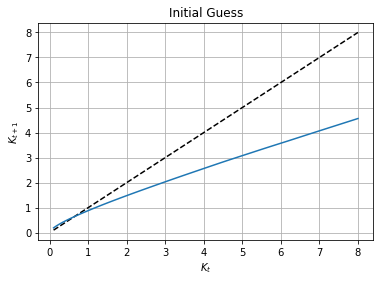

In [11]:
plt.plot(Kvec, Kvec, linestyle='--', color='black')
plt.plot(Kvec, Knvec.detach())
plt.xlabel("$K_t$")
plt.ylabel("$K_{t+1}$")
plt.title("Initial Guess")
plt.grid()

In [12]:
def Ξ(n): # objective function for DL training

    # randomly drawing current states
    A = torch.randn(n,1)*σ_e_A
    K = torch.rand(n,1)*(Kmax-Kmin)+Kmin
 
    # randomly drawing 1st realization for shocks
    e1_A = torch.randn(n,1)*σ_A

    # randomly drawing 2nd realization for shocks
    e2_A = torch.randn(n,1)*σ_A
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1 = Residuals(e1_A, A, K)
    R1_e2 = Residuals(e2_A, A, K)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 
    
    # compute average across n random draws
    return torch.mean(R_squared)

## Model testing
Let $h(y)$ denote the increase of utility tomorrow given shock $\epsilon^{\prime}$ is $y$: $\beta u^{\prime }\left(
c^{\prime }\right) \left( \alpha \exp ( A ^{\prime })  {K^{\prime }}^{\alpha-1}+1- \gamma \right)$ Then expected increase of utility is

\begin{equation}
E[h(y)] = \int_{-\infty}^{+\infty} \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{y^2}{2\sigma^2} \right) h(y)
\end{equation}

which can be approximated by using Gauss-Hermite quadrature:

\begin{equation}
E[h(y)] \approx \frac{1}{\sqrt{\pi}} \sum_{i=1}^N w_i h(\sqrt{2} \sigma x_i)
\end{equation}

In [13]:
def gauss_hermite_1D(N):
    nodes, weights = np.polynomial.hermite.hermgauss(N)
    nodes *= np.sqrt(2.0)
    weights *= 1.0 / np.sqrt(np.pi)
    return nodes, weights

In [14]:
def Residuals_hermgauss(A, K, evec_A, weights, N):

    # all inputs are expected to have the same size n
    n = A.size(0)

    # arguments correspond to the values of the states today
    c = dr(A,K)
    Knext = (torch.exp(A)*K.pow(α) + (1-γ)*K)*(1-c)
    
    MRC = torch.empty(n,N)
    
    for i in range(N):
        
        Anext = A*ρ_A + evec_A[i]
        C = (torch.exp(A)*K.pow(α) + (1-γ)*K)*c
        cnext = dr(Anext, Knext)
        Cnext = (torch.exp(Anext)*Knext.pow(α) + (1-γ)*Knext)*cnext
        mrc = β*(α*torch.exp(Anext)*Knext.pow(α-1)+1-γ)*(Cnext).pow(-σ)
        MRC[:,i] = mrc.squeeze(1)
    
    Weights = weights.unsqueeze(1).float()
    EMRC = MRC @ Weights
    R1 = 1.0-EMRC*(1/C).pow(-σ)

    return R1

In [15]:
def Ξ_test(n): # objective function for DL training

    # randomly drawing current states
    A = torch.randn(n,1)*σ_e_A
    K = torch.rand(n,1)*(Kmax-Kmin)+Kmin
 

    # residuals for n random grid points under 2 realizations of shocks
    R1_e1 = Residuals_hermgauss(A, K, evec_A, weights, N)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e1
    
    # compute average across n random draws
    return torch.mean(R_squared)

In [16]:
N = 21
n1 = 1000 # number of sample for test
nodes, weights = torch.tensor(gauss_hermite_1D(N))
evec_A = nodes*σ_A
vtest = []
vtest_aio = []

/var/folders/xn/khvmmtmj587826zjzpgz41fm0000gn/T/ipykernel_18017/2060222512.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  nodes, weights = torch.tensor(gauss_hermite_1D(N))


# Model training

We ramdomly choose n=128 values for training:

In [17]:
n = 128
v = Ξ(n)
vals = []

And we ramdomly choose n1=1000 values for testing:

In [18]:
for epoch in tqdm(range(max_epochs)):
    loss = Ξ(n)
    test = Ξ_test(n1)
    test_aio = Ξ(n1)
    vals.append(loss.detach())
    vtest.append(test.detach())
    vtest_aio.append(test_aio.detach())
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    scheduler.step()  

100%|██████████| 10000/10000 [06:28<00:00, 25.75it/s]


/var/folders/xn/khvmmtmj587826zjzpgz41fm0000gn/T/ipykernel_18017/3259678382.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(vals) )
/var/folders/xn/khvmmtmj587826zjzpgz41fm0000gn/T/ipykernel_18017/3259678382.py:15: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(vtest_aio) )


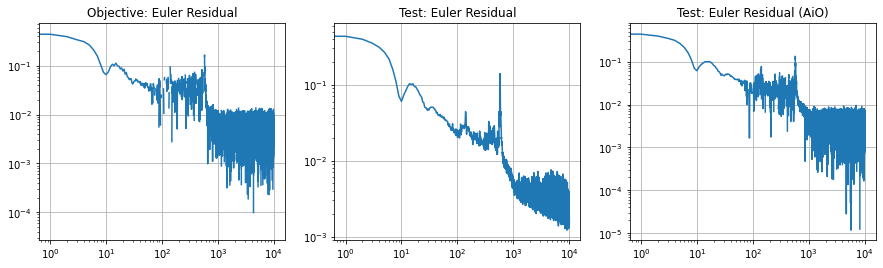

In [19]:
plt.figure().set_size_inches(15,4)
plt.subplot(1,3,1)
plt.plot(np.sqrt(vals) )
plt.title("Objective: Euler Residual")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.subplot(1,3,2)
plt.plot(np.sqrt(vtest) )
plt.title("Test: Euler Residual")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.subplot(1,3,3)
plt.plot(np.sqrt(vtest_aio) )
plt.title("Test: Euler Residual (AiO)")
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [24]:
VFIdata = scio.loadmat('/Users/siyuchen/Documents/VFI_AR1')
K,Value,Kprime,Consp = VFIdata['K'], VFIdata['V'],VFIdata['Kprime'],VFIdata['Consp']
nl, nm, nh = 4, 8, 12

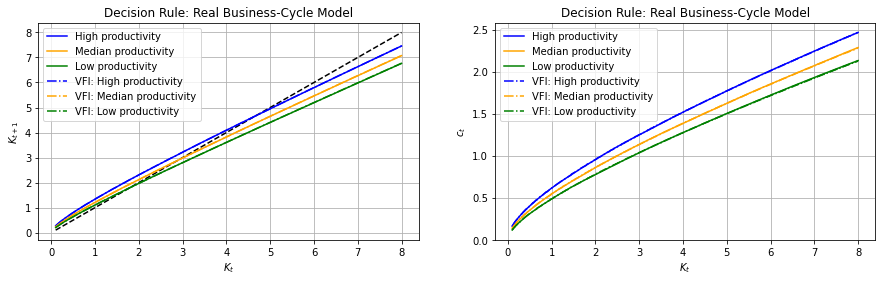

In [25]:
c_hat.eval()
Kvec = torch.linspace(Kmin, Kmax, 1000).unsqueeze(1)
Avec_h, Avec_m, Avec_l = torch.ones(1000,1)*0.1,torch.ones(1000,1)*(-0.1),torch.ones(1000,1)*(-0.3)
cvec_h, cvec_m, cvec_l = dr(Avec_h, Kvec), dr(Avec_m, Kvec), dr(Avec_l, Kvec)
Knvec_h, Knvec_m, Knvec_l = (torch.exp(Avec_h)*Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec_h), (torch.exp(Avec_m)*Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec_m), (torch.exp(Avec_l)*Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec_l)
Cvec_h, Cvec_m, Cvec_l = (torch.exp(Avec_h)*Kvec.pow(α) + (1-γ)*Kvec)*cvec_h, (torch.exp(Avec_m)*Kvec.pow(α) + (1-γ)*Kvec)*cvec_m, (torch.exp(Avec_l)*Kvec.pow(α) + (1-γ)*Kvec)*cvec_l

plt.figure().set_size_inches(15,4)
plt.subplot(1,2,1)
plt.plot(Kvec, Kvec, linestyle='--', color='black')
plt.plot(Kvec, Knvec_h.detach(),label= r"High productivity",color='blue')
plt.plot(Kvec, Knvec_m.detach(),label= r"Median productivity",color='orange')
plt.plot(Kvec, Knvec_l.detach(),label= r"Low productivity",color='green')
plt.plot(K, Kprime[:,nh],label= r"VFI: High productivity",color='blue',linestyle='-.')
plt.plot(K, Kprime[:,nm],label= r"VFI: Median productivity",color='orange',linestyle='-.')
plt.plot(K, Kprime[:,nl],label= r"VFI: Low productivity",color='green',linestyle='-.')
plt.xlabel("$K_t$")
plt.ylabel("$K_{t+1}$")
plt.title("Decision Rule: Real Business-Cycle Model")
plt.legend(loc='best')
plt.grid()
plt.subplot(1,2,2)
plt.plot(Kvec, Cvec_h.detach(),label= r"High productivity",color='blue')
plt.plot(Kvec, Cvec_m.detach(),label= r"Median productivity",color='orange')
plt.plot(Kvec, Cvec_l.detach(),label= r"Low productivity",color='green')
plt.plot(K, Consp[:,nh],label= r"VFI: High productivity",color='blue',linestyle='-.')
plt.plot(K, Consp[:,nm],label= r"VFI: Median productivity",color='orange',linestyle='-.')
plt.plot(K, Consp[:,nl],label= r"VFI: Low productivity",color='green',linestyle='-.')
plt.xlabel("$K_t$")
plt.ylabel("$c_{t}$")
plt.title("Decision Rule: Real Business-Cycle Model")
plt.legend(loc='best')
plt.grid()

In [26]:
torch.save([Cvec_h.detach(),Cvec_m.detach(),Cvec_l.detach(),Knvec_h.detach(),Knvec_m.detach(),Knvec_l.detach()],"./euler_0.pth")